In [23]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')

In [24]:
def load_data(file_path):
    """Load data from a CSV file into a pandas DataFrame."""
    return pd.read_csv(file_path)

pd.set_option('display.max_columns', None)
df = load_data('../data/supply_chain_data.csv')

# Sort columns alphabetically
df = df.reindex(sorted(df.columns), axis=1)

# Only SKU column put as the first column
cols_first = df.columns.tolist()
cols_first.insert(0, cols_first.pop(cols_first.index('SKU')))
df = df[cols_first]

# Rename SKU column to Order_id
df = df.rename(columns={'SKU': 'Order_id'})
df.head()

,Order_id,Availability,Costs,Customer demographics,Defect rates,Inspection results,Lead time,Lead times,Location,Manufacturing costs,Manufacturing lead time,Number of products sold,Order quantities,Price,Product type,Production volumes,Revenue generated,Routes,Shipping carriers,Shipping costs,Shipping times,Stock levels,Supplier name,Transportation modes
0,SKU0,55,187.752075,Non-binary,0.226410,Pending,29,7,Mumbai,46.279879,29,802,96,69.808006,haircare,215,8661.996792,Route B,Carrier B,2.956572,4,58,Supplier 3,Road
1,SKU1,95,503.065579,Female,4.854068,Pending,23,30,Mumbai,33.616769,30,736,37,14.843523,skincare,517,7460.900065,Route B,Carrier A,9.716575,2,53,Supplier 3,Road
2,SKU2,34,141.920282,Unknown,4.580593,Pending,12,10,Mumbai,30.688019,27,8,88,11.319683,haircare,971,9577.749626,Route C,Carrier B,8.054479,2,1,Supplier 1,Air
3,SKU3,68,254.776159,Non-binary,4.746649,Fail,24,13,Kolkata,35.624741,18,83,59,61.163343,skincare,937,7766.836426,Route A,Carrier C,1.729569,6,23,Supplier 5,Rail
4,SKU4,26,923.440632,Non-binary,3.145580,Fail,5,3,Delhi,92.065161,3,871,56,4.805496,skincare,414,2686.505152,Route A,Carrier A,3.890548,8,5,Supplier 1,Air


## Function to expand data

- Added multiple rows around 2000-4000 for data handling
- to ensure data not underfitting

In [25]:
def expand_data(df, target_rows=4000, random_seed=42):
    np.random.seed(random_seed)

    repeat_factor = target_rows // len(df) + 1
    df_expanded = pd.concat([df] * repeat_factor, ignore_index=True)
    df_expanded = df_expanded.sample(n=target_rows, random_state=random_seed).reset_index(drop=True)

    return df_expanded

## Add noises data for make a data into realize

In [26]:
def add_noise(df):
    df = df.copy()

    # Numeric noise addition
    noise_config = {
        "Price": 0.05,
        "Shipping costs": 0.1,
        "Manufacturing costs": 0.08,
        "Defect rates": 0.02
    }

    # Iterable noise addition
    for col, noise_level in noise_config.items():
        if col in df.columns:
            df[col] = df[col] * (1 + np.random.normal(0, noise_level, size=len(df)))
            df[col] = df[col].clip(lower=0)  # Ensure no negative values

    # Integer noise addition columns
    int_cols = [
        "Stock levels",
        "Order quantities",
        "Production volumes",
        "Shipping times",
        "Lead times"
    ]

    for col in int_cols:
        if col in df.columns:
            df[col] = (df[col] + np.random.randint(-2, 3, size=len(df))).clip(lower=0)

    return df

In [27]:
df = expand_data(df, target_rows=4000, random_seed=42)
df = add_noise(df)
df = df.sort_values(by='Order_id').reset_index(drop=True)

## Feature Engineering

- Ensure data noise into normal data for preventing duplicate data
- Order_id change to numeric random to get unique ID

In [28]:
import uuid


np.random.seed(42)

namespace = uuid.NAMESPACE_DNS
df["Order_id"] = [str(uuid.uuid5(namespace=namespace, name=str(i))) for i in range(len(df))]

numeric_cols = ["Costs", 'Manufacturing costs', 'Price', 'Revenue generated', 'Shipping costs']

for col in numeric_cols:
    # Added variety about +/- 1% from the original value
    noise = np.random.normal(1.0, 0.01, size=len(df))
    df[col] = df[col] * noise

In [29]:
df.head()

,Order_id,Availability,Costs,Customer demographics,Defect rates,Inspection results,Lead time,Lead times,Location,Manufacturing costs,Manufacturing lead time,Number of products sold,Order quantities,Price,Product type,Production volumes,Revenue generated,Routes,Shipping carriers,Shipping costs,Shipping times,Stock levels,Supplier name,Transportation modes
0,6af613b6-569c-5c22-9c37-2ed93f31d3af,55,188.684667,Non-binary,0.224447,Pending,29,8,Mumbai,43.469393,29,802,98,71.933529,haircare,214,8763.759148,Route B,Carrier B,2.601292,6,59,Supplier 3,Road
1,b04965e6-a9bb-591f-8f8a-1adcb2c8dc39,55,187.492481,Non-binary,0.226086,Pending,29,8,Mumbai,51.332779,29,802,95,70.933955,haircare,213,8499.239523,Route B,Carrier B,3.220109,3,58,Supplier 3,Road
2,4b166dbe-d99d-5091-abdd-95b83330ed3a,55,188.968124,Non-binary,0.231951,Pending,29,9,Mumbai,47.134300,29,802,98,72.899584,haircare,213,8633.603195,Route B,Carrier B,3.257622,2,57,Supplier 3,Road
3,98123fde-012f-5ff3-8b50-881449dac91a,55,190.611596,Non-binary,0.233616,Pending,29,8,Mumbai,53.945541,29,802,98,65.259225,haircare,213,8658.388203,Route B,Carrier B,3.040814,6,59,Supplier 3,Road
4,6ed955c6-506a-5343-9be4-2c0afae02eef,55,187.312448,Non-binary,0.221073,Pending,29,8,Mumbai,40.762402,29,802,95,77.743599,haircare,216,8663.374800,Route B,Carrier B,2.703847,3,57,Supplier 3,Road


In [30]:
df.describe()

,Availability,Costs,Defect rates,Lead time,Lead times,Manufacturing costs,Manufacturing lead time,Number of products sold,Order quantities,Price,Production volumes,Revenue generated,Shipping costs,Shipping times,Stock levels
count,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.000000,4000.00000
mean,48.37275,529.711616,2.285820,17.136000,15.922500,47.227280,14.79025,461.596500,49.181000,49.430165,567.561000,5770.944224,5.538579,5.761500,47.85900
std,30.58172,256.963159,1.451593,8.781104,8.841354,29.202608,8.86391,302.706627,26.642376,31.162825,261.431203,2720.729508,2.715884,2.997476,31.21395
min,1.00000,101.211166,0.017856,1.000000,0.000000,0.932373,1.00000,8.000000,0.000000,1.560650,102.000000,1046.762838,0.753234,0.000000,0.00000
25%,22.75000,316.570584,1.014768,10.000000,8.000000,22.345539,7.00000,176.000000,26.000000,19.246846,356.000000,2788.710268,3.303343,3.000000,17.00000
50%,43.00000,521.373219,2.155420,18.000000,16.000000,44.810631,14.00000,391.000000,52.500000,50.843918,568.000000,5994.144648,5.390601,6.000000,47.00000
75%,75.00000,765.712622,3.574428,25.000000,24.000000,69.528746,23.00000,705.000000,71.000000,76.427830,795.250000,8256.243186,7.696807,8.000000,73.00000
max,100.00000,1021.467838,5.174818,30.000000,32.000000,118.544393,30.00000,996.000000,98.000000,116.464410,987.000000,10065.689055,12.160134,12.000000,102.00000


In [31]:
df["Defect rates"]

0       0.224447
1       0.226086
2       0.231951
3       0.233616
4       0.221073
          ...   
3995    0.349242
3996    0.359944
3997    0.357211
3998    0.367761
3999    0.342171
Name: Defect rates, Length: 4000, dtype: float64

In [32]:
# Create damage risk boolean label with 0 = SAFE shipment, 1 = HIGH RISK shipment
def assign_damage_risk(defect_rate):
    if defect_rate > 0.15:
        return 1  # HIGH RISK
    else:
        return 0  # SAFE

df["damage_risk"] = df["Defect rates"].apply(assign_damage_risk)
df["damage_risk"].value_counts()

1    3762
0     238
Name: damage_risk, dtype: int64

In [33]:
df.head()

,Order_id,Availability,Costs,Customer demographics,Defect rates,Inspection results,Lead time,Lead times,Location,Manufacturing costs,Manufacturing lead time,Number of products sold,Order quantities,Price,Product type,Production volumes,Revenue generated,Routes,Shipping carriers,Shipping costs,Shipping times,Stock levels,Supplier name,Transportation modes,damage_risk
0,6af613b6-569c-5c22-9c37-2ed93f31d3af,55,188.684667,Non-binary,0.224447,Pending,29,8,Mumbai,43.469393,29,802,98,71.933529,haircare,214,8763.759148,Route B,Carrier B,2.601292,6,59,Supplier 3,Road,1
1,b04965e6-a9bb-591f-8f8a-1adcb2c8dc39,55,187.492481,Non-binary,0.226086,Pending,29,8,Mumbai,51.332779,29,802,95,70.933955,haircare,213,8499.239523,Route B,Carrier B,3.220109,3,58,Supplier 3,Road,1
2,4b166dbe-d99d-5091-abdd-95b83330ed3a,55,188.968124,Non-binary,0.231951,Pending,29,9,Mumbai,47.134300,29,802,98,72.899584,haircare,213,8633.603195,Route B,Carrier B,3.257622,2,57,Supplier 3,Road,1
3,98123fde-012f-5ff3-8b50-881449dac91a,55,190.611596,Non-binary,0.233616,Pending,29,8,Mumbai,53.945541,29,802,98,65.259225,haircare,213,8658.388203,Route B,Carrier B,3.040814,6,59,Supplier 3,Road,1
4,6ed955c6-506a-5343-9be4-2c0afae02eef,55,187.312448,Non-binary,0.221073,Pending,29,8,Mumbai,40.762402,29,802,95,77.743599,haircare,216,8663.374800,Route B,Carrier B,2.703847,3,57,Supplier 3,Road,1


In [34]:
df["Defect rates"].describe()

count    4000.000000
mean        2.285820
std         1.451593
min         0.017856
25%         1.014768
50%         2.155420
75%         3.574428
max         5.174818
Name: Defect rates, dtype: float64

# Create Features

In [35]:
# Logistic features
delay_margin = df["Shipping times"] - df["Lead times"]
cost_per_hour = df["Shipping costs"] / df["Shipping times"]

# Container load features
load_pressure = df["Order quantities"] / df["Production volumes"]
stock_stress = df["Stock levels"] / df["Order quantities"]

# Manufacturing quality features
supplier_defect_avg = df["Defect rates"].rolling(window=5, min_periods=1).mean()
cost_quality_ratio  = df["Manufacturing costs"] / df["Production volumes"]

# Training pipelines

In [36]:
# Training pipelines == define features and target variable
y = df["damage_risk"]
X = df[[
    "Shipping times",
    "Shipping costs",
    "Transportation modes",
    "Routes",
    "Order quantities",
    "Production volumes",
    "Manufacturing costs",
    "Supplier name"
]]

# Data encoding

In [37]:
# Encoding categorical features
for obj in X.select_dtypes(include=['object']).columns:
    X[obj] = X[obj].astype('category').cat.codes

# Split data into X and y

In [39]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Data scaling (Optional if needed)

# Machine learning models

In [40]:
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score
)
import pandas as pd
import json

models_params = {

    "Logistic Regression": {
        "model": LogisticRegression(
            max_iter=500,
            class_weight="balanced",
            random_state=42
        ),
        "params": {
            "C": [0.01, 0.1, 1, 10],
            "solver": ["lbfgs"]
        }
    },

    "Decision Tree": {
        "model": DecisionTreeClassifier(
            class_weight="balanced",
            random_state=42
        ),
        "params": {
            "max_depth": [4, 6, 8],
            "min_samples_leaf": [10, 20, 50],
            "criterion": ["gini", "entropy"]
        }
    },

    "LightGBM": {
        "model": LGBMClassifier(
            class_weight="balanced",
            random_state=42
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [-1, 6, 10],
            "learning_rate": [0.05, 0.1],
            "num_leaves": [31, 64]
        }
    },

    "XGBoost": {
        "model": XGBClassifier(
            eval_metric="logloss",
            use_label_encoder=False,
            random_state=42
        ),
        "params": {
            "n_estimators": [100, 200],
            "max_depth": [4, 6],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0]
        }
    }
}

results_data = []
best_models = {}

for model_name, config in models_params.items():
    print(f"Training {model_name}...")

    grid = GridSearchCV(
        estimator=config["model"],
        param_grid=config["params"],
        scoring="roc_auc",
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid.fit(X_train, y_train)

    best_model= grid.best_estimator_
    best_models[model_name] = best_model

    # Predictions
    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]

    results_data.append({
        "Model": model_name,
        "Best Parameters": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Precision": precision_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1 Score": f1_score(y_test, y_pred),
        "ROC AUC": roc_auc_score(y_test, y_prob)
    })

# Results DataFrame
results_df = pd.DataFrame(results_data)
results_df = results_df.sort_values(by="F1 Score", ascending=False).reset_index(drop=True)

print("Model Evaluation Results:")
print(results_df.to_string(index=False))

# Select best model
best_model_name = results_df.iloc[0]["Model"]
final_model = best_models[best_model_name]
print(f"Best Model Selected: {best_model_name}")

Training Logistic Regression...
Fitting 5 folds for each of 4 candidates, totalling 20 fits


KeyboardInterrupt: 

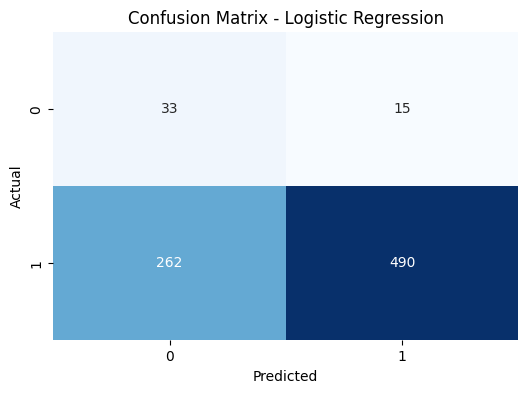

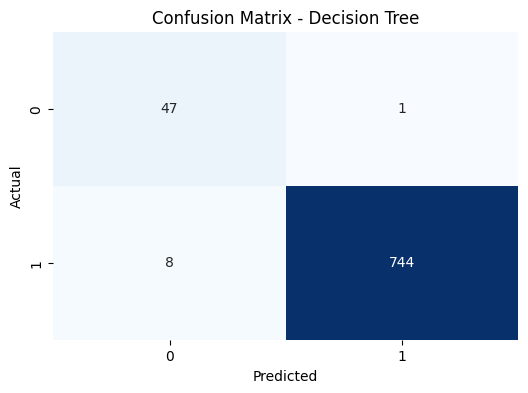

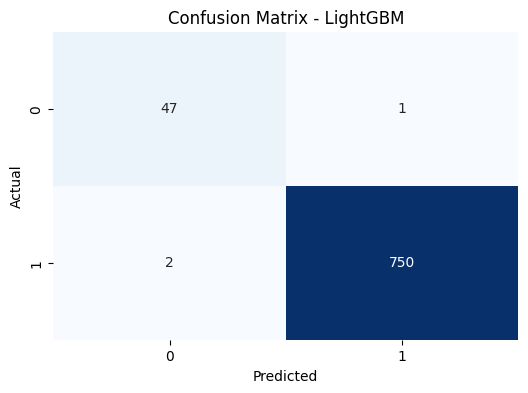

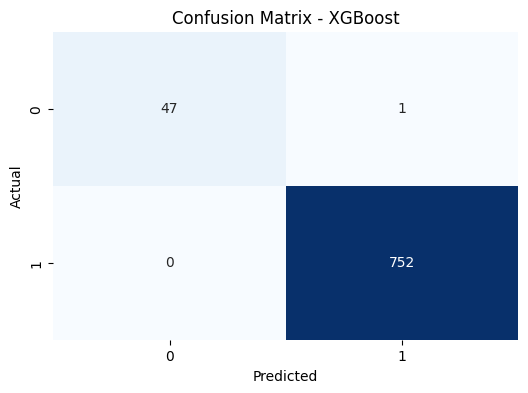

In [ ]:
# Visualize models for confusion matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Iterate all models into confusion matrix plots
for model_name, model in best_models.items():
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.show()

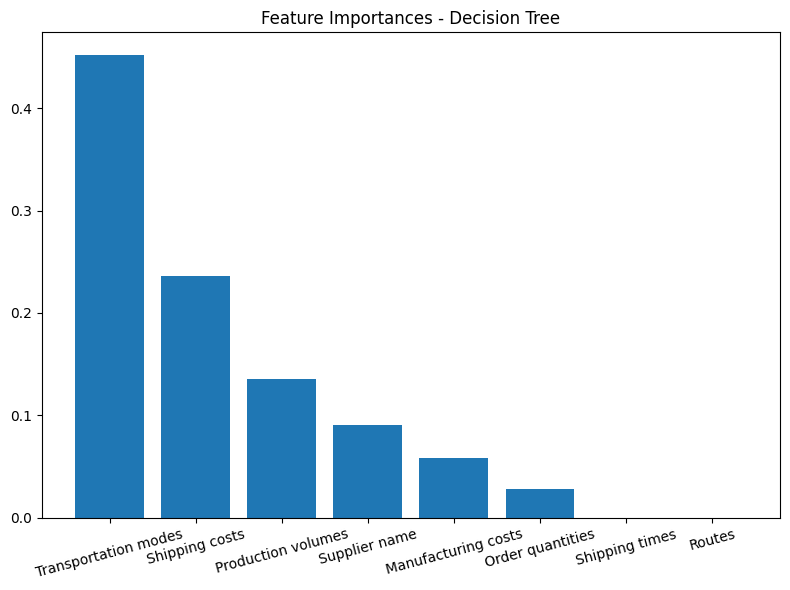

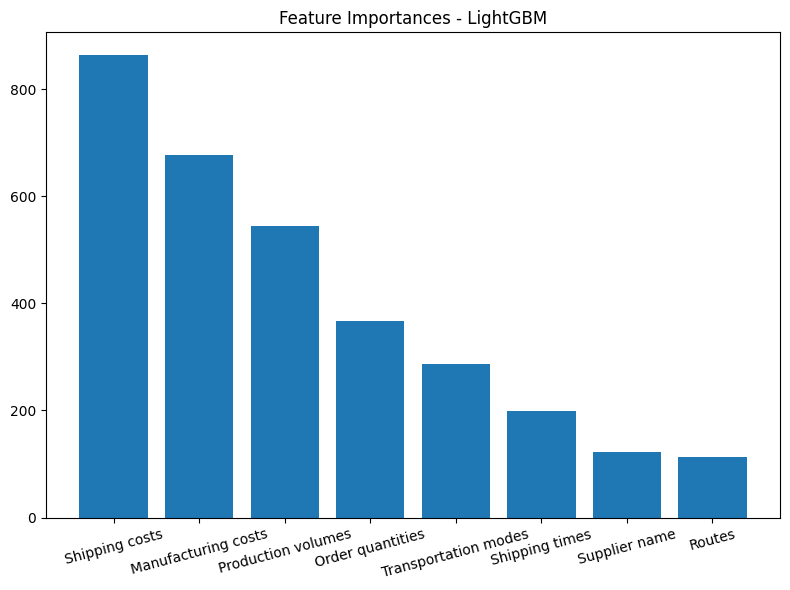

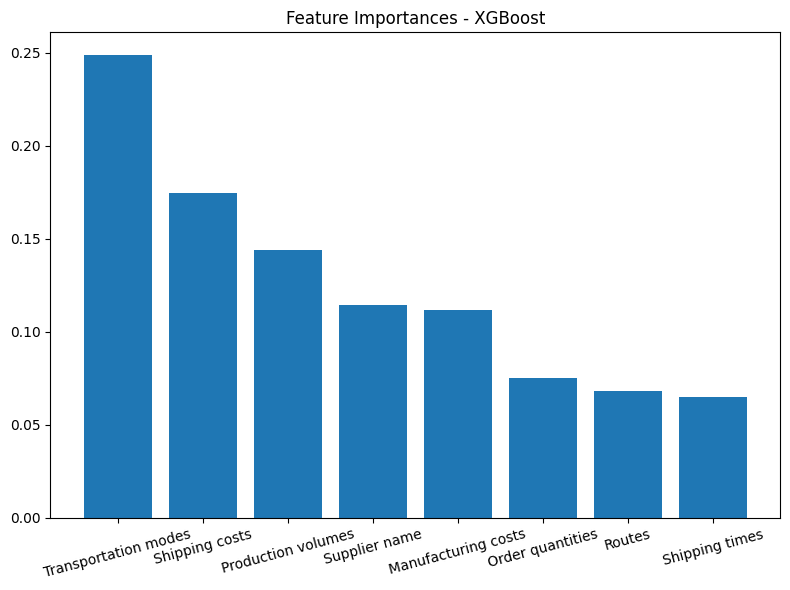

In [ ]:
# Feature importance for all models that support it
for model_name, model in best_models.items():
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 6))
        plt.title(f'Feature Importances - {model_name}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=15)
        plt.tight_layout()
        plt.show()

# Save for best models

In [ ]:
# Save all models, metrics, hyperparameters, feature list, Dataset Version ,  Confusion Matrix Plot, ROC Curve Plot,  Feature Importance Plot, metadata
#import joblib
#import os
#import matplotlib.pyplot as plt
#from sklearn.metrics import roc_curve

MODEL_DIR = "../models/"
os.makedirs(MODEL_DIR, exist_ok=True)

# Save as classified such example if logistic regression so make it directory as logistic_regression
for model_name, model in best_models.items():
    model_dir = os.path.join(MODEL_DIR, model_name.replace(" ", "_").lower())
    os.makedirs(model_dir, exist_ok=True)

    # Save model as .pkl
    model_path = os.path.join(model_dir, "model.pkl")
    joblib.dump(model, model_path)

    # Save metrics and hyperparameters
    metrics = results_df[results_df["Model"] == model_name].to_dict(orient="records")[0]
    with open(os.path.join(model_dir, "metrics.json"), "w") as f:
        json.dump(metrics, f, indent=4)

    # Save feature list
    with open(os.path.join(model_dir, "features.txt"), "w") as f:
        for feature in X.columns:
            f.write(f"{feature}\n")

    # Save ROC Curve Plot
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.figure()
    plt.plot(fpr, tpr, label=f'ROC curve (area = {metrics["ROC AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.savefig(os.path.join(model_dir, "roc_curve.png"))
    plt.close()

    # Save Confusion Matrix Plot
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix - {model_name}')
    plt.savefig(os.path.join(model_dir, "confusion_matrix.png"))
    plt.close()

    # Save Feature Importance Plot
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(8, 6))
        plt.title(f'Feature Importances - {model_name}')
        plt.bar(range(X.shape[1]), importances[indices], align='center')
        plt.xticks(range(X.shape[1]), X.columns[indices], rotation=15)
        plt.tight_layout()
        plt.savefig(os.path.join(model_dir, "feature_importance.png"))
        plt.close()

    # Save dataset version
    df.to_csv(os.path.join(model_dir, "training_data.csv"), index=False)
    print(f"Saved model and artifacts for {model_name} in {model_dir}")

    # Save metadata
    metadata = {
        "model_name": model_name,
        "model_path": model_path,
        "training_data_shape": df.shape,
        "features": X.columns.tolist(),
        "target": "damage_risk"
    }
    with open(os.path.join(model_dir, "metadata.json"), "w") as f:
        json.dump(metadata, f, indent=4)


Saved model and artifacts for Logistic Regression in ../models/logistic_regression
Saved model and artifacts for Decision Tree in ../models/decision_tree
Saved model and artifacts for LightGBM in ../models/lightgbm
Saved model and artifacts for XGBoost in ../models/xgboost


# Load all directory saved

In [ ]:
# Load all directory saved
import joblib
import os
import json
MODEL_DIR = "../models/"

for model_folder in os.listdir(MODEL_DIR):
    model_dir = os.path.join(MODEL_DIR, model_folder)
    if os.path.isdir(model_dir):
        # Load model
        model_path = os.path.join(model_dir, "model.pkl")
        model = joblib.load(model_path)
        print(f"Loaded model from {model_path}")

        # Load metrics
        with open(os.path.join(model_dir, "metrics.json"), "r") as f:
            metrics = json.load(f)
        print(f"Metrics: {metrics}")

        # Load features
        with open(os.path.join(model_dir, "features.txt"), "r") as f:
            features = f.read().splitlines()
        print(f"Features: {features}")

        # Load metadata
        with open(os.path.join(model_dir, "metadata.json"), "r") as f:
            metadata = json.load(f)
        print(f"Metadata: {metadata}")

Loaded model from ../models/logistic_regression/model.pkl
Metrics: {'Model': 'Logistic Regression', 'Best Parameters': {'C': 10, 'solver': 'lbfgs'}, 'Accuracy': 0.65375, 'Precision': 0.9702970297029703, 'Recall': 0.651595744680851, 'F1 Score': 0.7796340493237868, 'ROC AUC': 0.6678579343971632}
Features: ['Shipping times', 'Shipping costs', 'Transportation modes', 'Routes', 'Order quantities', 'Production volumes', 'Manufacturing costs', 'Supplier name']
Metadata: {'model_name': 'Logistic Regression', 'model_path': '../models/logistic_regression/model.pkl', 'training_data_shape': [4000, 25], 'features': ['Shipping times', 'Shipping costs', 'Transportation modes', 'Routes', 'Order quantities', 'Production volumes', 'Manufacturing costs', 'Supplier name'], 'target': 'damage_risk'}
Loaded model from ../models/xgboost/model.pkl
Metrics: {'Model': 'XGBoost', 'Best Parameters': {'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 100, 'subsample': 0.8}, 'Accuracy': 0.99875, 'Precision': 0.

In [ ]:
# Example prediction with loaded model
sample_data = X_test.iloc[0:1]
predicted_risk = model.predict(sample_data)
predicted_prob = model.predict_proba(sample_data)[:, 1]
print(f"Predicted Damage Risk: {predicted_risk[0]}, Probability: {predicted_prob[0]:.4f}")

Predicted Damage Risk: 1, Probability: 1.0000
